# Multi-Variable Time-Series : CO2 prediction

The goal is to take 64 hours of data (64 time steps) of Multi-Variable Time-Series and predict 16 hours ahead of the fist Time-Serie (CO2 - or level of polution ). 

We will do classifiction. The prediction will fall into 5 classes :

Level 0 - Very low CO2

Level 1 

level 2

level 3 

level 4 - Very high CO2


In [3]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('../raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('../pollution.csv')


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


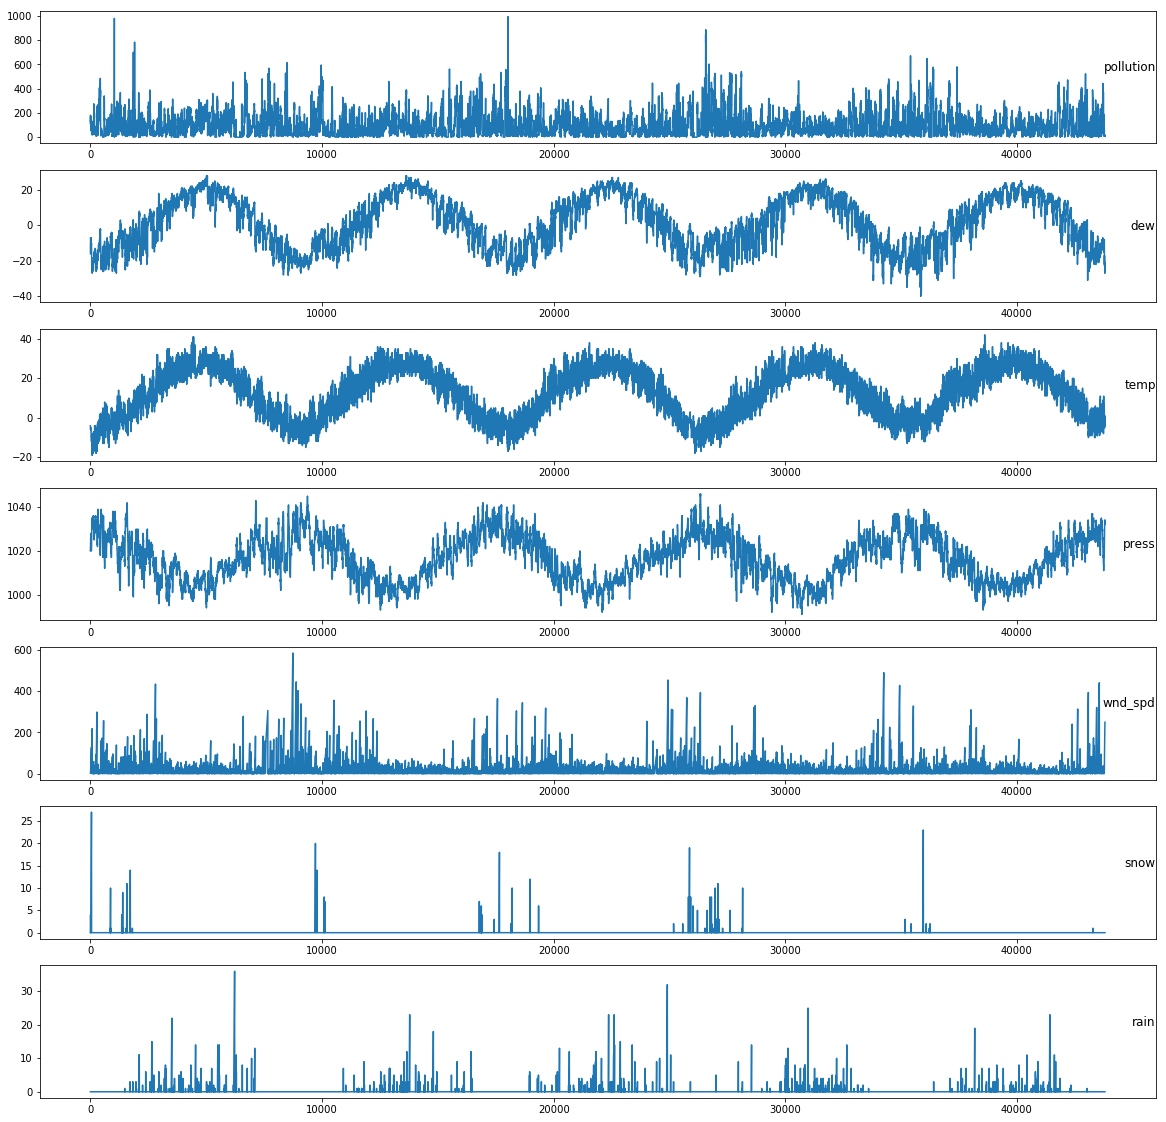

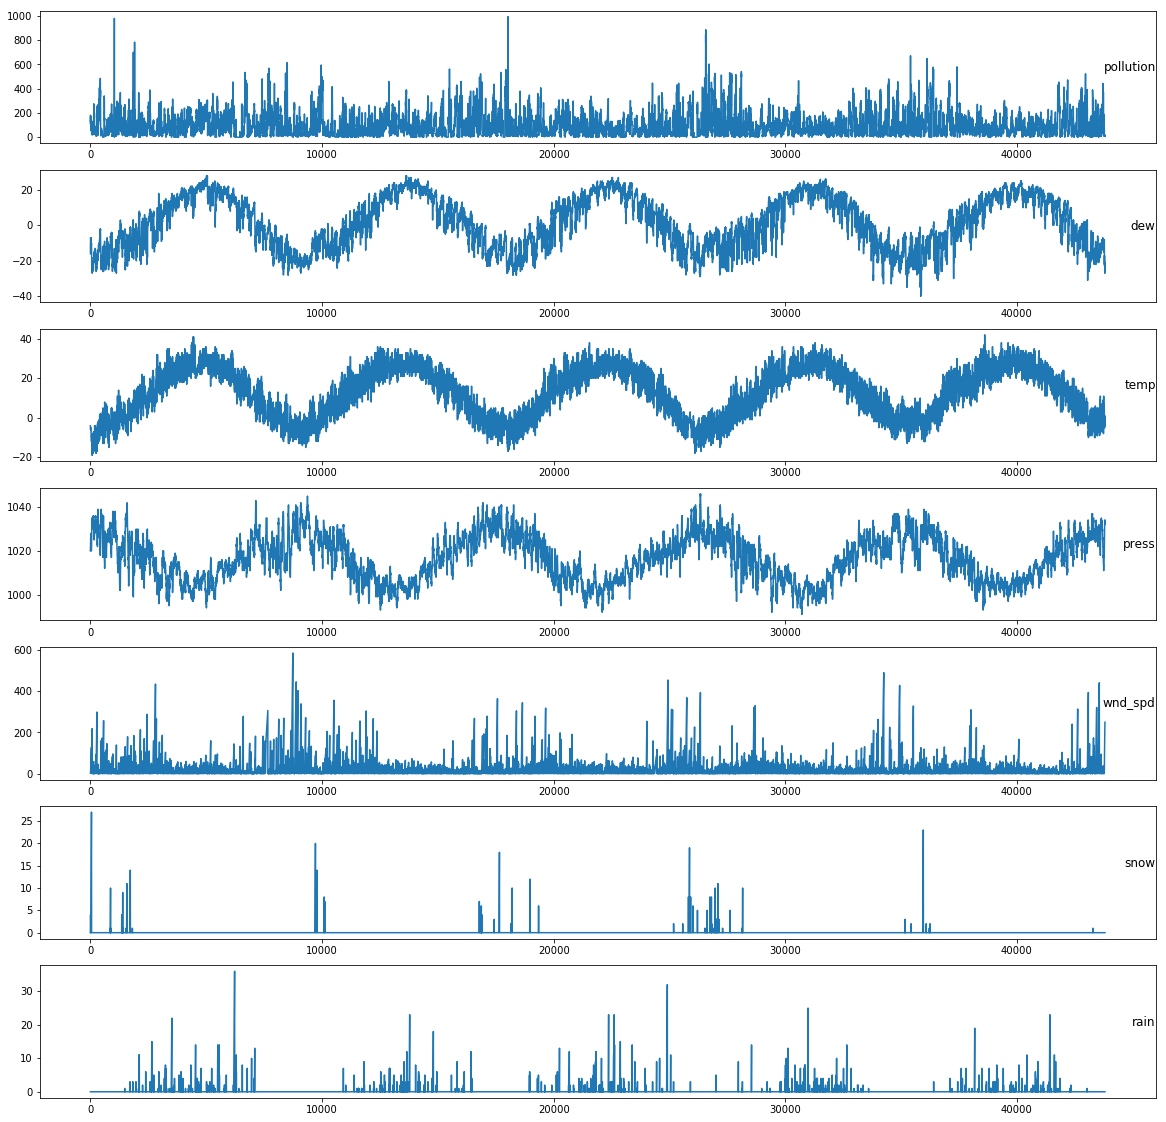

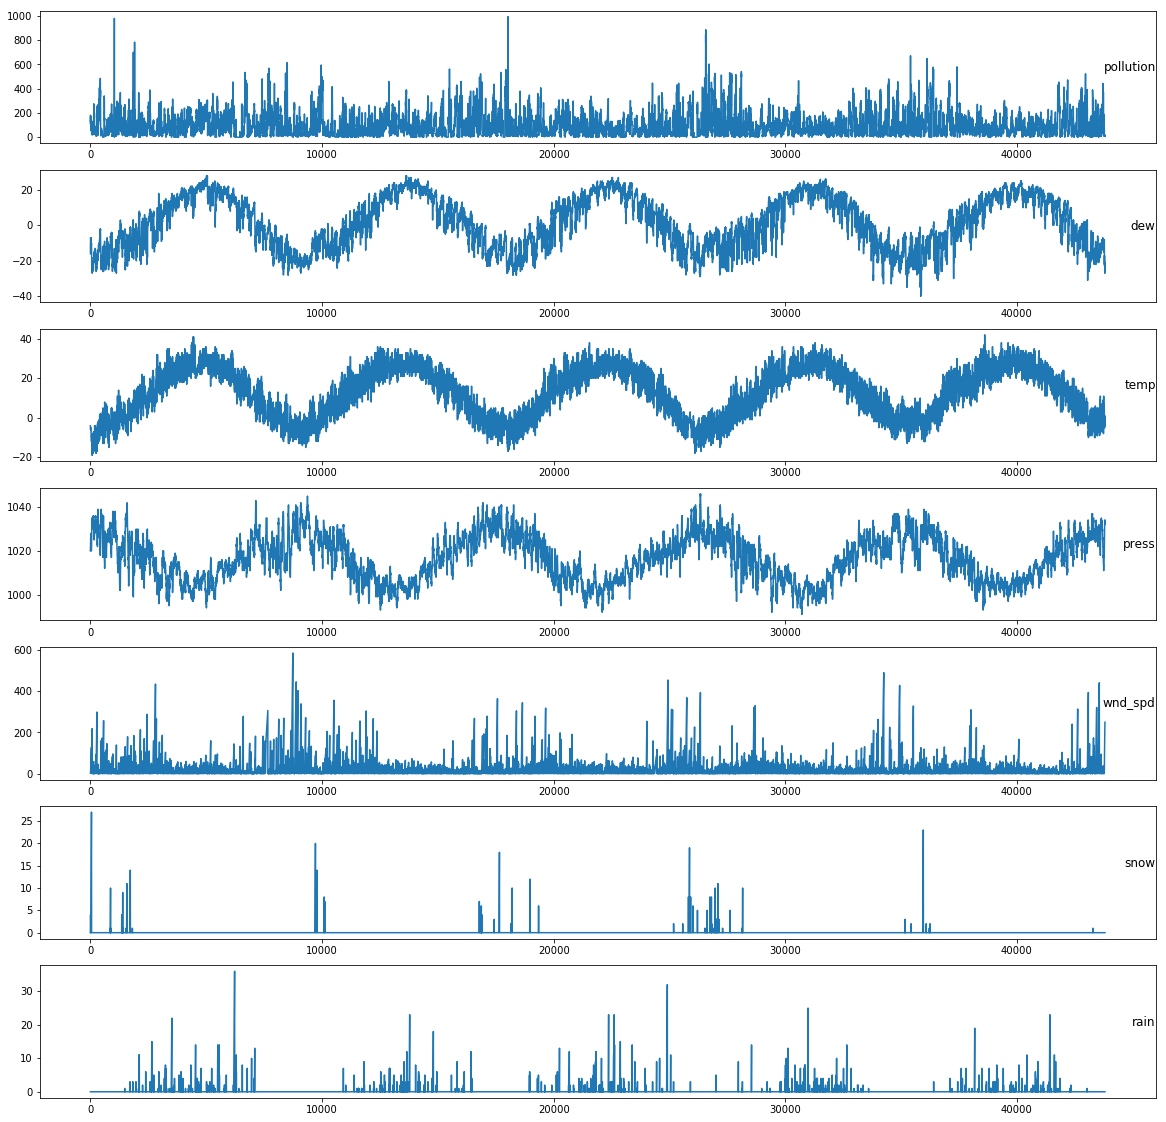

In [6]:
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
# load dataset
dataset = read_csv('../pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column

#pyplot.figure()
pyplot.figure(figsize=(20,20))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.savefig("test2.svg", format="svg")
pyplot.show()


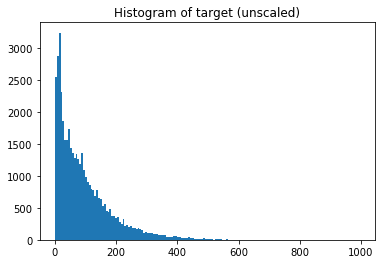

In [7]:
import matplotlib.pyplot as plt
plt.hist(values[:, 0], bins='auto') 
plt.title("Histogram of target (unscaled)")
plt.savefig("test.svg", format="svg")
plt.show()


In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
    

In [10]:
# load dataset
dataset = read_csv('../pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 64
n_features = 8
N_hours_ahead = 16
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, N_hours_ahead)
print(reframed.shape)
print(reframed)

(43721, 640)
       var1(t-64)  var2(t-64)  var3(t-64)  var4(t-64)  var5(t-64)  var6(t-64)  \
64       0.129779    0.352941    0.245902    0.527273    0.666667    0.002290   
65       0.148893    0.367647    0.245902    0.527273    0.666667    0.003811   
66       0.159960    0.426471    0.229508    0.545454    0.666667    0.005332   
67       0.182093    0.485294    0.229508    0.563637    0.666667    0.008391   
68       0.138833    0.485294    0.229508    0.563637    0.666667    0.009912   
69       0.109658    0.485294    0.213115    0.563637    0.666667    0.011433   
70       0.105634    0.485294    0.213115    0.581818    0.666667    0.014492   
71       0.124748    0.485294    0.229508    0.600000    0.666667    0.017551   
72       0.120724    0.470588    0.213115    0.600000    0.666667    0.020610   
73       0.132797    0.485294    0.229508    0.618183    0.666667    0.023669   
74       0.140845    0.485294    0.229508    0.636364    0.666667    0.029018   
75       0.1529

In [11]:
print()

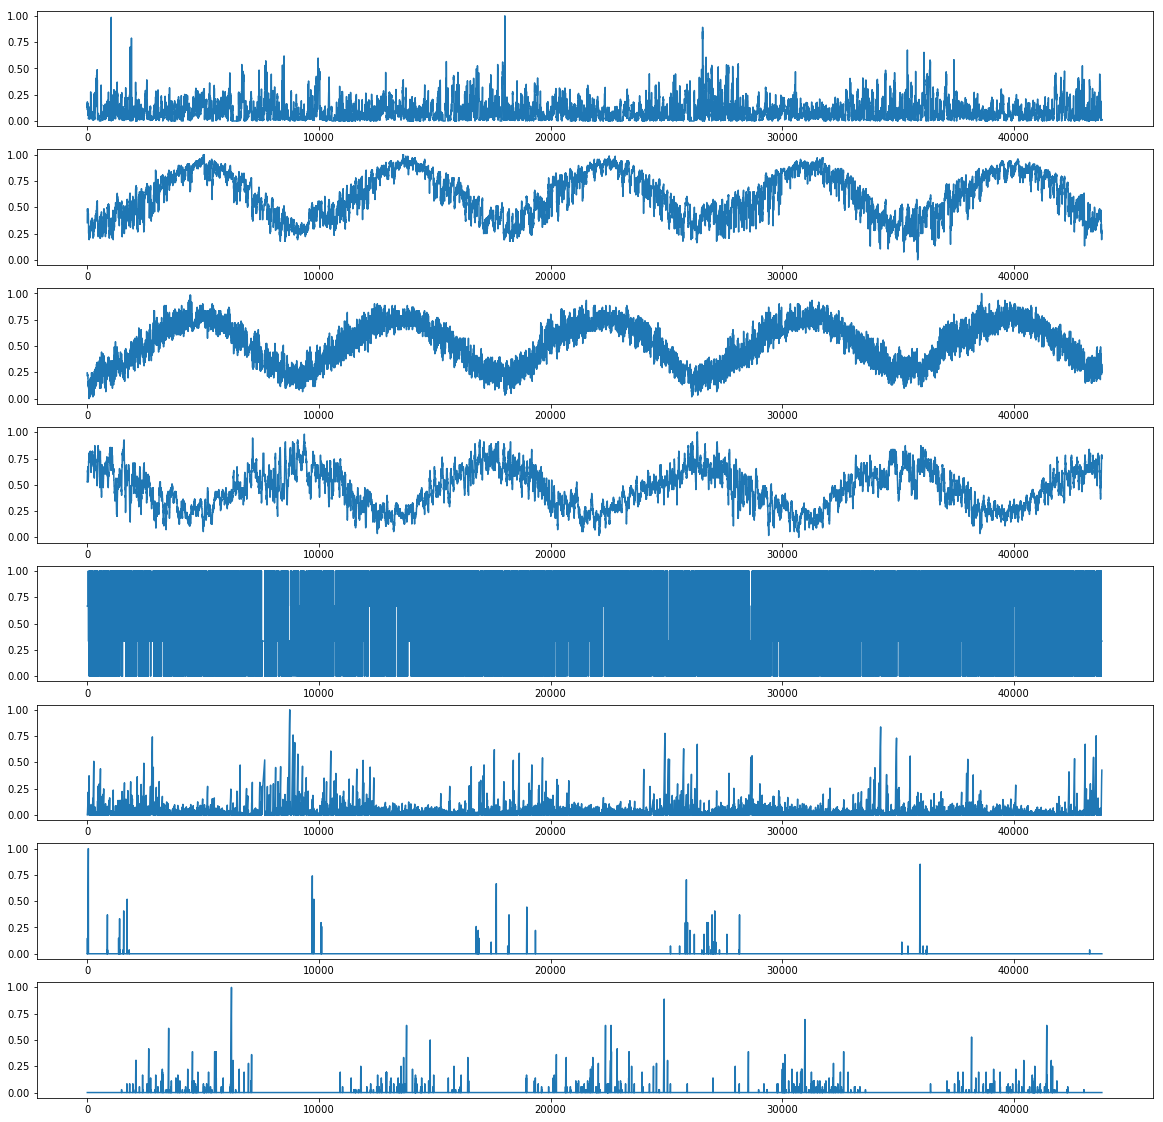

In [12]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = scaled

# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column

#pyplot.figure()
pyplot.figure(figsize=(20,20))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(scaled[:, group])
    #pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1

pyplot.show()

In [13]:
print ("shape of reframe", reframed.shape)

shape of reframe (43721, 640)


In [14]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print("train[0] : \n",train[0])
print("train[0].shape : \n",train[0].shape)
print("train : \n",train[0, -n_features])

#################################################################
## SAVE all values of target to conver into classification then
## using histogram in java ...
#################################################################
import numpy
a = numpy.asarray(values[:, -n_features])
print("array : " , a)
numpy.savetxt("../foo.csv", a,fmt='%1.10f', delimiter=",") 


# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



train[0] : 
 [  1.29778668e-01   3.52941215e-01   2.45901629e-01   5.27273178e-01
   6.66666687e-01   2.29001138e-03   0.00000000e+00   0.00000000e+00
   1.48893356e-01   3.67647082e-01   2.45901629e-01   5.27273178e-01
   6.66666687e-01   3.81098920e-03   0.00000000e+00   0.00000000e+00
   1.59959748e-01   4.26470608e-01   2.29508191e-01   5.45454025e-01
   6.66666687e-01   5.33196656e-03   0.00000000e+00   0.00000000e+00
   1.82092547e-01   4.85294133e-01   2.29508191e-01   5.63636780e-01
   6.66666687e-01   8.39101151e-03   3.70370373e-02   0.00000000e+00
   1.38832986e-01   4.85294133e-01   2.29508191e-01   5.63636780e-01
   6.66666687e-01   9.91198886e-03   7.40740746e-02   0.00000000e+00
   1.09657943e-01   4.85294133e-01   2.13114738e-01   5.63636780e-01
   6.66666687e-01   1.14329662e-02   1.11111112e-01   0.00000000e+00
   1.05633803e-01   4.85294133e-01   2.13114738e-01   5.81817627e-01
   6.66666687e-01   1.44920116e-02   1.48148149e-01   0.00000000e+00
   1.24748483e-01   4

In [15]:
print ("example 1 :\n", train_X[0])
print ("example 1 shape :\n", train_X[0].shape)
print ("expected target 1 :\n", train_y[0])
print ("train_y.shape : ", train_y.shape)


example 1 :
 [[  1.29778668e-01   3.52941215e-01   2.45901629e-01   5.27273178e-01
    6.66666687e-01   2.29001138e-03   0.00000000e+00   0.00000000e+00]
 [  1.48893356e-01   3.67647082e-01   2.45901629e-01   5.27273178e-01
    6.66666687e-01   3.81098920e-03   0.00000000e+00   0.00000000e+00]
 [  1.59959748e-01   4.26470608e-01   2.29508191e-01   5.45454025e-01
    6.66666687e-01   5.33196656e-03   0.00000000e+00   0.00000000e+00]
 [  1.82092547e-01   4.85294133e-01   2.29508191e-01   5.63636780e-01
    6.66666687e-01   8.39101151e-03   3.70370373e-02   0.00000000e+00]
 [  1.38832986e-01   4.85294133e-01   2.29508191e-01   5.63636780e-01
    6.66666687e-01   9.91198886e-03   7.40740746e-02   0.00000000e+00]
 [  1.09657943e-01   4.85294133e-01   2.13114738e-01   5.63636780e-01
    6.66666687e-01   1.14329662e-02   1.11111112e-01   0.00000000e+00]
 [  1.05633803e-01   4.85294133e-01   2.13114738e-01   5.81817627e-01
    6.66666687e-01   1.44920116e-02   1.48148149e-01   0.00000000e+00]


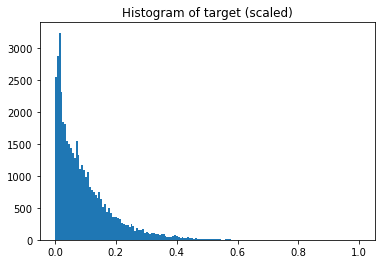

In [16]:
import matplotlib.pyplot as plt
plt.hist(values[:, -n_features], bins='auto') 
plt.title("Histogram of target (scaled)")
plt.show()


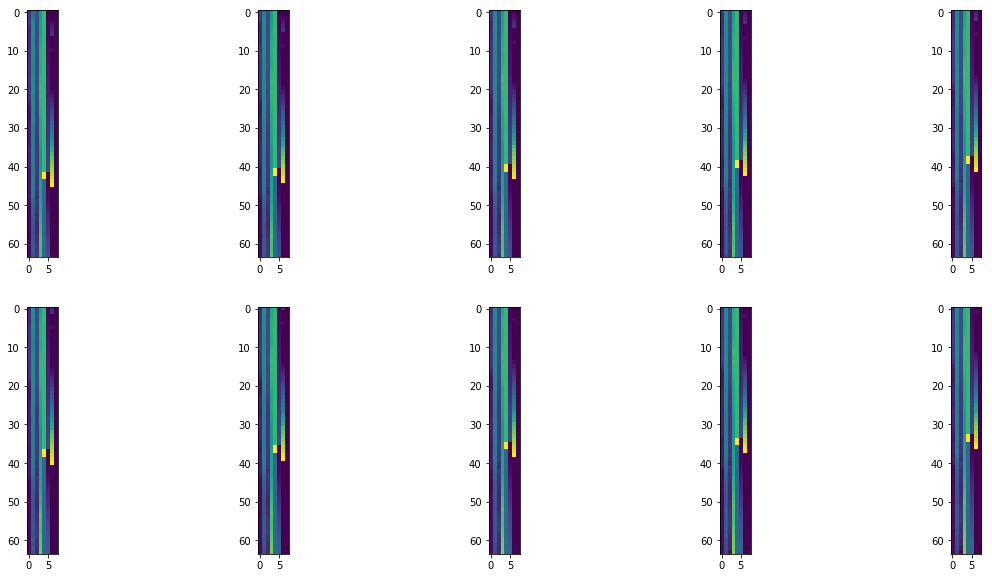

In [17]:
import matplotlib.pyplot as plt
n=10
plt.figure(figsize=(20,10))
for i in range(n):
    # display original
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(train_X[i])
    #plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

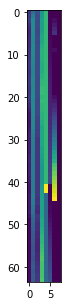

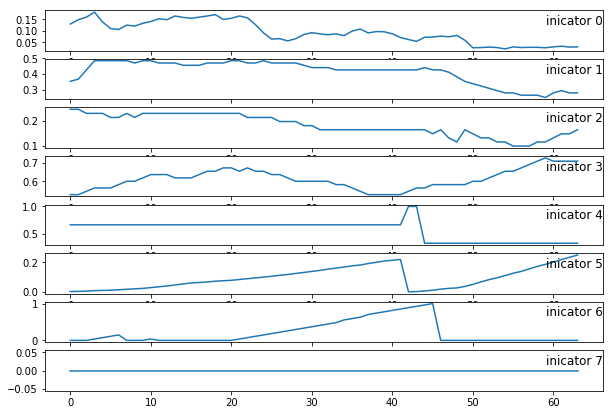

 the normalized regression value to predict for this example is :  0.027163


In [18]:
plt.figure(figsize=(5,5))
plt.imshow(train_X[1])
#plt.gray()
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
plt.show()


from matplotlib import pyplot
groups = [0, 1, 2, 3, 4,5,6,7]
values=train_X[0]
i=1
plt.figure(figsize=(10,7))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:,group])
	pyplot.title("inicator "+str(group), y=0.5, loc='right')
	i += 1
pyplot.show()

print (" the normalized regression value to predict for this example is : ", train_y[0])


## Transforming output into a classification problem using histogram for equalitarium number of records for each class (5) : 

![alt text](images/CO2-target-histogram-classes.png "Title")

The normalized values for segmentation are: 

Level 0 : [ 0.0 , 0.0189999988675999960.0]<br>
Level 1 : [ 0.0189999988675999960.0 , 0.048999997079599990.0]<br>
Level 2 : [ 0.048999997079599990.0 , 0.089999994635999980.0]<br>
Level 3 : [ 0.089999994635999980.0 , 0.153999990821599970.0]<br>
Level 4 : [ 0.153999990821599970.0 , 1.0]<br><br>

these values were found using a java program. We will use this values harcoded in python to build the new target set. 


In [28]:
from keras.utils import np_utils

def fromNumberToClassEncoded(values,intervals):
    
    target = []
    for x in values:
        #print(x)
        for n in range(0,len(intervals)):
            if x > intervals[n][0] and x <= intervals[n][1] :
                target.append(n)
            #    print(n)
            #print(intervals[n][0],"  ", intervals[n][1])
            
    print ("Value to class :\n" , values[32],target[32])
    hotEncoded = np_utils.to_categorical(target, len(intervals))
    print("hot encoded : \n ", hotEncoded[32])
    return hotEncoded ,  target



In [80]:
levels = [[ -1.0 , 0.0189999988675999960],
          [ 0.0189999988675999960 , 0.048999997079599990],
          [ 0.048999997079599990 , 0.089999994635999980],
          [ 0.089999994635999980 , 0.153999990821599970],
          [ 0.153999990821599970 , 1.0]
        ]

print()
train_Y ,values_train = fromNumberToClassEncoded(train_y,levels)
test_Y ,values_test = fromNumberToClassEncoded(test_y,levels)

print("train_y.shape (original)", train_y.shape)
print("train_Y.shape (in classes)", train_Y.shape)



Value to class :
 0.0492958 2
hot encoded : 
  [ 0.  0.  1.  0.  0.]
Value to class :
 0.0130785 0
hot encoded : 
  [ 1.  0.  0.  0.  0.]
train_y.shape (original) (8760,)
train_Y.shape (in classes) (8760, 5)


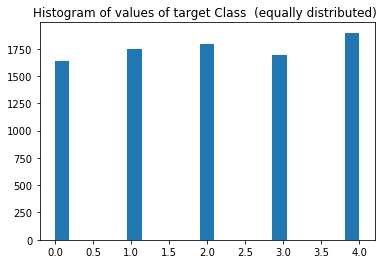

In [85]:
plt.hist(values_train, bins='auto') 
plt.title("Histogram of values of target Class  (equally distributed) ")
plt.show()

In [73]:
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

class LeNet:
	@staticmethod
	def build(timeSteps, variables , classes):
		model = Sequential()
		input_shape= (1, timeSteps, variables)
        # CONV => RELU => POOL
		# kernel size (width, height) default (2,5)
		model.add(Conv2D(20, kernel_size=(2,2), padding="same",
			input_shape=input_shape))
		model.add(Activation("relu"))
		# pool size - down scale int factor (vertical, horizontal)
		model.add(MaxPooling2D(pool_size=(2,1),strides=(2, 1)))
		# CONV => RELU => POOL
		
		model.add(Conv2D(50, kernel_size=(3,3), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2,1),strides=(2, 1))) #1,2
		#model.summary()
		model.add(Dropout(0.40))
		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(400))
		model.add(Activation("relu"))
		model.add(Dropout(0.5))
		model.add(Dense(150))
		model.add(Activation("relu"))
		model.add(Dropout(0.8))
		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		#model.add(Dropout(0.3)) # not logical to do droput on last layer with softmax 
		return model


In [74]:
import numpy as np
from keras import backend as K

#adapt shape for CNN
X_train = train_X[:, np.newaxis, :, :]

n_hours = 64
n_features = 8

K.set_image_dim_ordering("th")

model = LeNet.build(timeSteps=n_hours,variables=n_features,classes=len(levels))

model.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=["accuracy"])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 20, 64, 8)         100       
_________________________________________________________________
activation_61 (Activation)   (None, 20, 64, 8)         0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 20, 32, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 32, 8)         9050      
_________________________________________________________________
activation_62 (Activation)   (None, 50, 32, 8)         0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 50, 16, 8)         0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 50, 16, 8)         0         
__________

In [82]:
NB_EPOCH = 1
# network and training
BATCH_SIZE = 64
VERBOSE = 1
VALIDATION_SPLIT=0.2

# Initialize all variables
#sess.run(tf.global_variables_initializer())


tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

history = model.fit(X_train, train_Y, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=2, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_split=VALIDATION_SPLIT, callbacks=[tbCallBack,reduce_lr,esCallBack])



Train on 7008 samples, validate on 1752 samples
Epoch 1/1
46s - loss: 1.5961 - acc: 0.2433 - val_loss: 1.5854 - val_acc: 0.3156


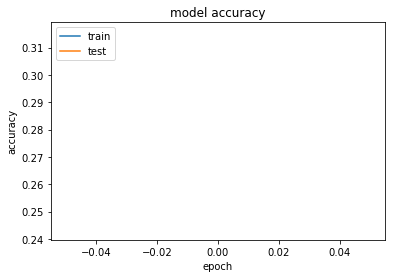

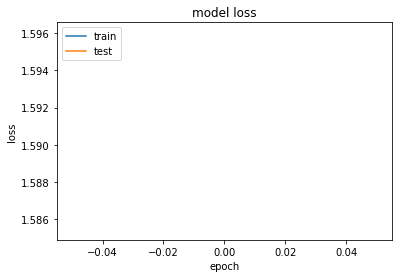

In [84]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
class LSTMNet:
    @staticmethod
    def build(timeSteps,variables,classes):
        #CONV=>POOL
        inputNet = Input(shape=(timeSteps,variables),batch_shape=(20, 7, 5)) 
        #lstm=Bidirectional(LSTM(100,recurrent_dropout=0.4,dropout=0.4),merge_mode='concat')(inputNet) #worse using stateful=True
        lstm=Bidirectional(LSTM(50),merge_mode='concat')(inputNet) #worse using stateful=True 
        #denselayers=Dense(400)(lstm)
        #denselayers=Activation("relu")(denselayers)
        #denselayers=Dropout(0.5)(denselayers)
        #denselayers=Dense(150)(denselayers)
        #denselayers=Activation("relu")(denselayers)
        #denselayers=Dropout(0.8)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(classes,activation='softmax')(lstm)
        #classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model